In [21]:
# @title Connect To Google Drive { run: "auto", vertical-output: true, form-width: "50px" }
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# @title Import Library { run: "auto", vertical-output: true, form-width: "50px" }
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import io
import requests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn
import seaborn as sns
import os

from copy import deepcopy as dc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.utils import shuffle
from scipy.stats import pearsonr, shapiro
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score


**DATA COLLECTION**

In [23]:
# @title Import Dataset { form-width: "50px" }

py_file_location = "/content/drive/MyDrive/WIA1006"
sys.path.append(os.path.abspath(py_file_location))

oilGas_csv = '/content/drive/MyDrive/WIA1006/oil_and_gas_data.csv'
oilGas_df = pd.read_csv(oilGas_csv)

print(oilGas_df.head())

      Symbol        Date   Open   High    Low  Close  Volume Currency
0  Brent Oil  2000-01-04  23.90  24.70  23.89  24.39   32509      USD
1  Brent Oil  2000-01-05  24.25  24.37  23.70  23.73   30310      USD
2  Brent Oil  2000-01-06  23.55  24.22  23.35  23.62   44662      USD
3  Brent Oil  2000-01-07  23.57  23.98  23.05  23.09   34826      USD
4  Brent Oil  2000-01-10  23.04  23.78  23.04  23.73   26388      USD


**Feature Selection/ Extraction**

(5768, 7)
(5744, 7)
(5770, 7)
(5742, 7)
             Symbol        Date   Open   High    Low  Close  Volume Currency
5768  Crude Oil WTI  2000-01-04  25.20  25.69  24.71  25.55   74788      USD
5769  Crude Oil WTI  2000-01-05  25.50  25.61  24.87  24.91   70944      USD
5770  Crude Oil WTI  2000-01-06  24.80  25.34  24.51  24.78   85252      USD
5771  Crude Oil WTI  2000-01-07  24.65  25.00  24.15  24.22   91828      USD
5772  Crude Oil WTI  2000-01-10  24.22  24.75  24.02  24.67   68901      USD


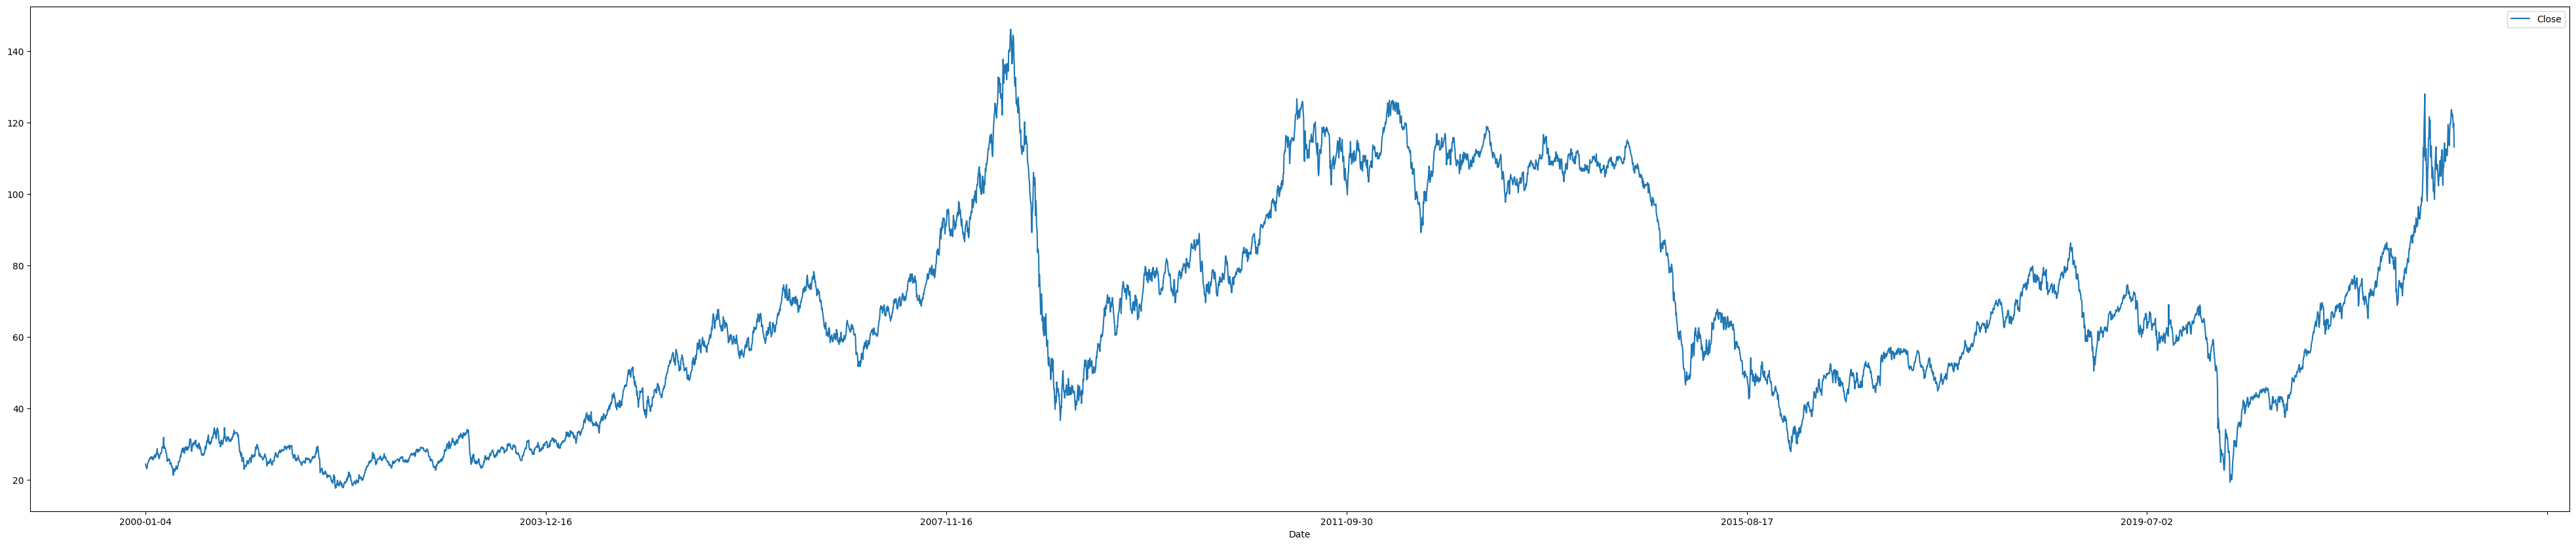

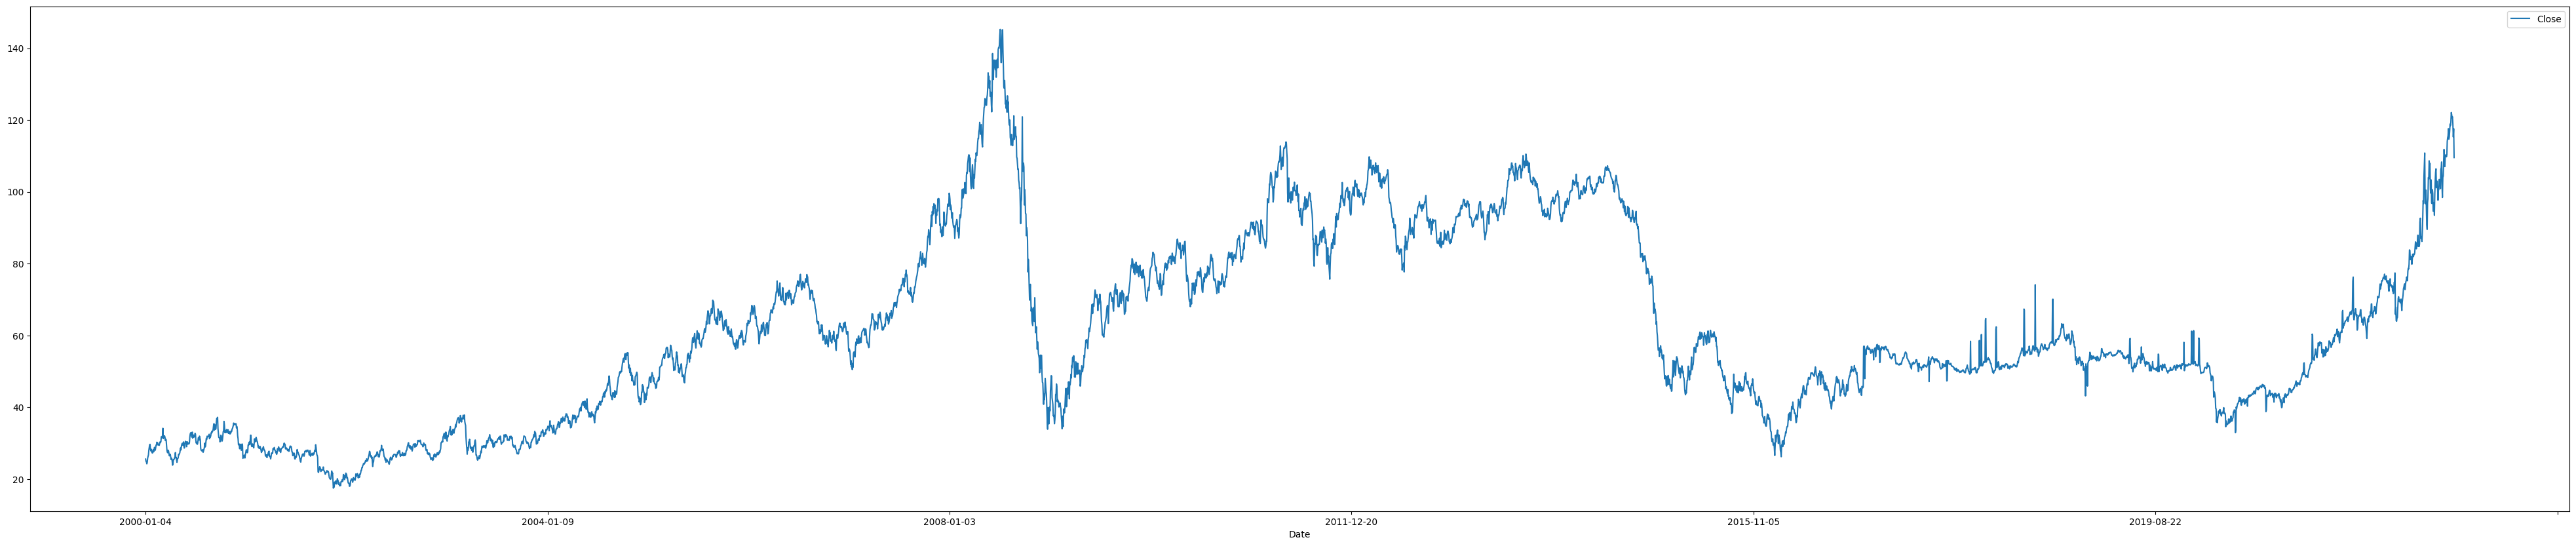

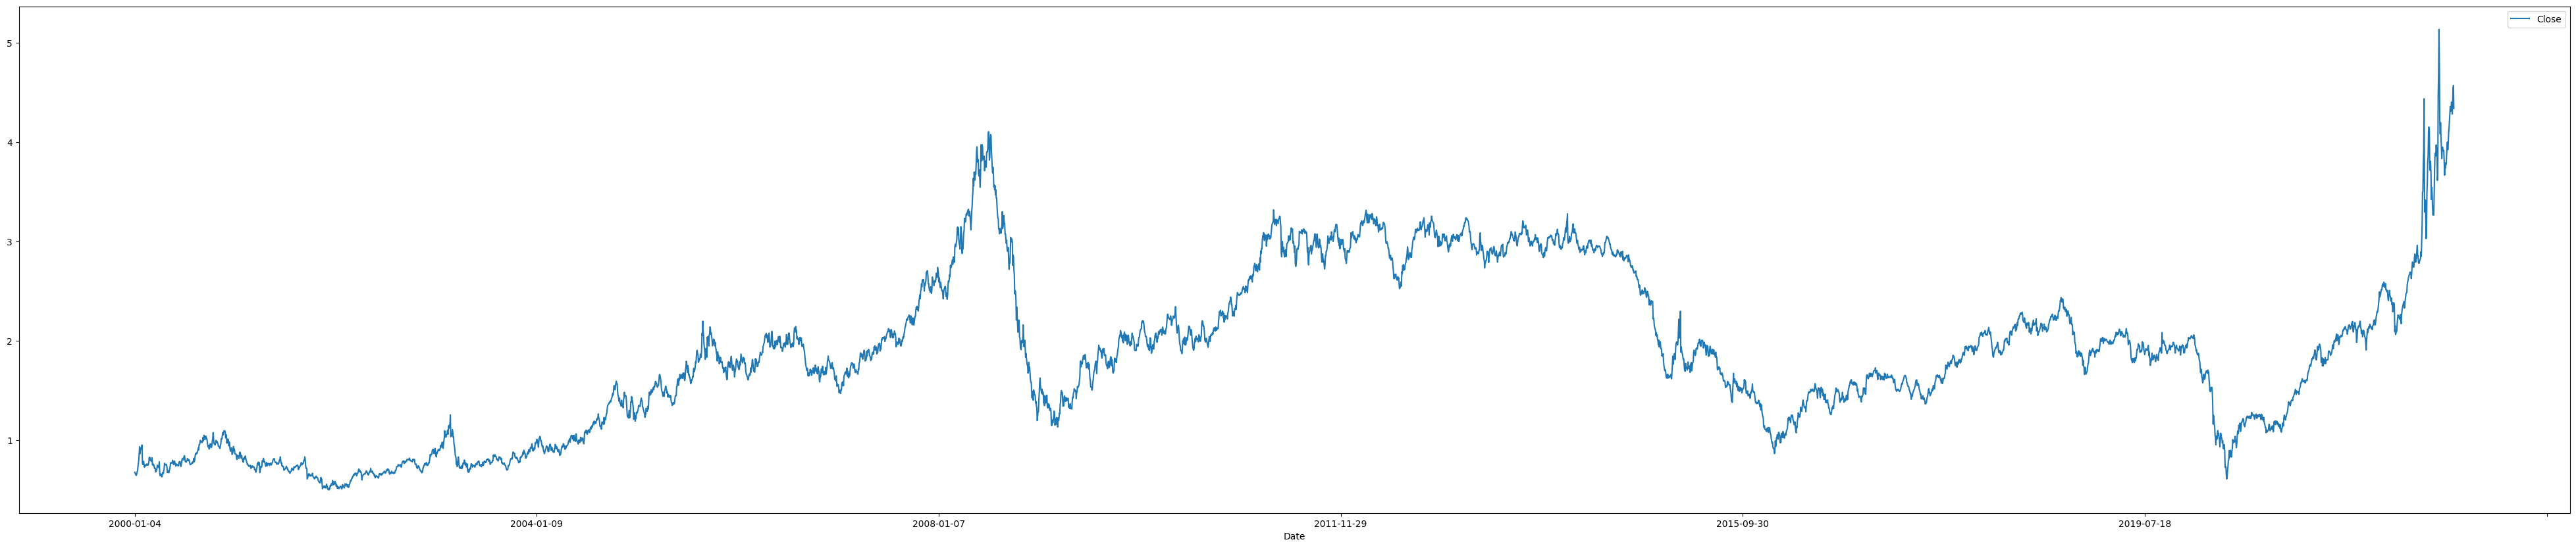

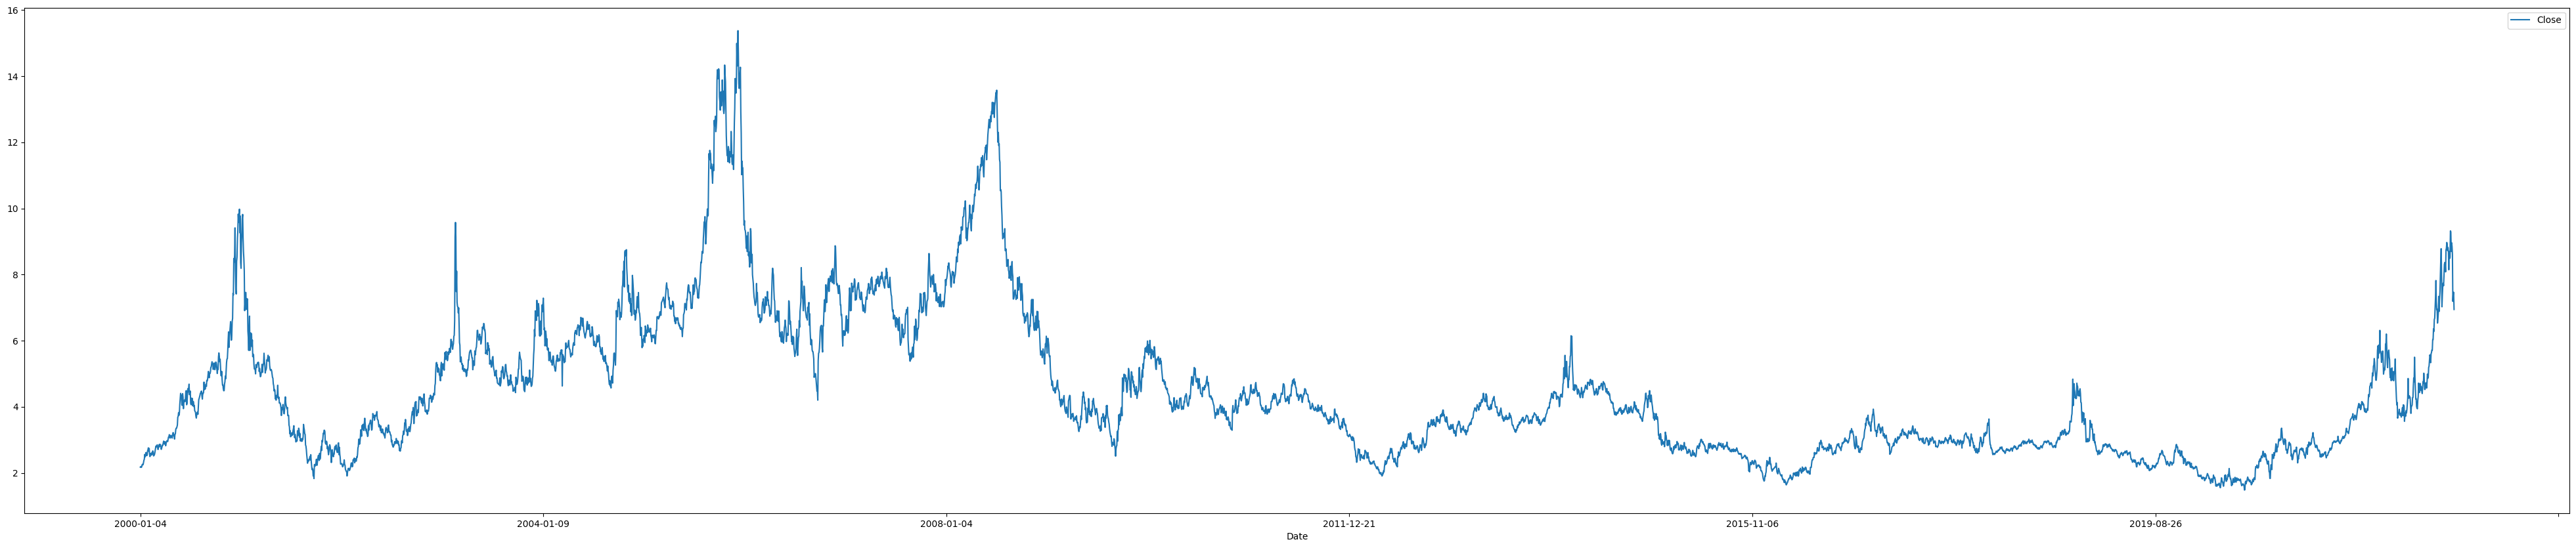

In [24]:
# @title Splitting Oil Type { form-width: "50px" }

oilGas_df_list = [d for _, d in oilGas_df.groupby(['Symbol'])]

# Showing the difference between each oil
temp_brentOil_df = oilGas_df_list[0].drop(['Symbol'], axis=1)
print(temp_brentOil_df.shape)
temp_brentOil_df.plot(legend=True, x='Date', y='Close', figsize=(50, 10))

temp_crudeOil_df = oilGas_df_list[1].drop(['Symbol'], axis=1)
print(temp_crudeOil_df.shape)
temp_crudeOil_df.plot(legend=True, x='Date', y='Close', figsize=(50, 10))

temp_heatingOil_df = oilGas_df_list[2].drop(['Symbol'], axis=1)
print(temp_heatingOil_df.shape)
temp_heatingOil_df.plot(legend=True, x='Date', y='Close', figsize=(50, 10))

temp_naturalOil_df = oilGas_df_list[3].drop(['Symbol'], axis=1)
print(temp_naturalOil_df.shape)
temp_naturalOil_df.plot(legend=True, x='Date', y='Close', figsize=(50, 10))

# Remove Symbol
crudeOil_df = oilGas_df_list[1]
print(crudeOil_df.head())
crudeOil_df = oilGas_df_list[1].drop(['Symbol'], axis=1)

**DATA PREPROCESSING**

In [25]:
# @title Impute Dataset { run: "auto", form-width: "50px" }

# ################################# Impute DatasSet ################################################
def impute_dataset(df: pd.DataFrame):
    cols = df.columns

    for column in df.select_dtypes(include=['number']).columns:
        mean_value = df[column].mean()

        df[column].fillna(mean_value, inplace=True)


impute_dataset(crudeOil_df)


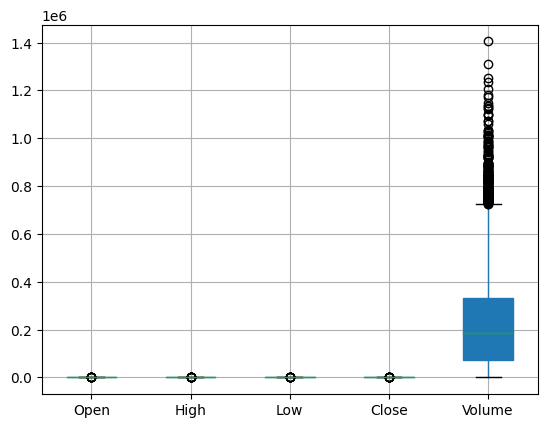

             Date    Open    High     Low   Close  Volume Currency
5768   2000-01-04   25.20   25.69   24.71   25.55   74788      USD
5769   2000-01-05   25.50   25.61   24.87   24.91   70944      USD
5770   2000-01-06   24.80   25.34   24.51   24.78   85252      USD
5771   2000-01-07   24.65   25.00   24.15   24.22   91828      USD
5772   2000-01-10   24.22   24.75   24.02   24.67   68901      USD
...           ...     ...     ...     ...     ...     ...      ...
11507  2022-06-13  120.19  122.25  117.47  120.93  372403      USD
11508  2022-06-14  121.09  123.68  116.62  118.93  366320      USD
11509  2022-06-15  119.07  119.61  114.60  115.31  301750      USD
11510  2022-06-16  115.98  118.08  112.31  117.59  162543      USD
11511  2022-06-17  117.08  118.97  108.25  109.56       0      USD

[5496 rows x 7 columns]


In [26]:
# @title Remove Outliers { form-width: "50px" }

def check_outlier(df: pd.DataFrame):
    curr_df = df
    cols = curr_df.columns

    curr_df.boxplot(patch_artist=True)
    plt.show()


check_outlier(crudeOil_df)


def remove_outliers(df: pd.DataFrame):
    curr_df = df
    cols = curr_df.columns

    for i in range(len(cols)):
        col = cols[i]

        if col == 'Close':
            continue

        if curr_df[col].dtypes == 'object':
            continue

        Q1 = curr_df[col].quantile(0.25)
        Q3 = curr_df[col].quantile(0.75)

        IQR = Q3 - Q1

        Lower_Range = Q1 - (1.5 * IQR)
        Upper_Range = Q3 + (1.5 * IQR)

        # count = ((curr_df[col] < Lower_Range) | (curr_df[col] > Upper_Range)).sum()
        curr_df = curr_df[~((curr_df[col] < Lower_Range) | (curr_df[col] > Upper_Range))]

    return curr_df


crudeOil_df = remove_outliers(crudeOil_df)
print(crudeOil_df)


In [27]:
# @title Remove Duplicate Column { form-width: "50px" }

def remove_duplicate_column(df: pd.DataFrame):
    curr_df = df
    cols = curr_df.columns

    for i in range(len(cols)):
        col = cols[i]
        curr_arr = curr_df[col].unique()
        # print(curr_arr)

        if (len(curr_arr) == 1):
            curr_df = curr_df.drop(col, axis=1)

    return curr_df

print("Dataset before removing duplicate: ")
print(crudeOil_df.head())
print()
crudeOil_df = remove_duplicate_column(crudeOil_df)
print("Dataset after removing duplicate: ")
print(crudeOil_df.head())

Dataset before removing duplicate: 
            Date   Open   High    Low  Close  Volume Currency
5768  2000-01-04  25.20  25.69  24.71  25.55   74788      USD
5769  2000-01-05  25.50  25.61  24.87  24.91   70944      USD
5770  2000-01-06  24.80  25.34  24.51  24.78   85252      USD
5771  2000-01-07  24.65  25.00  24.15  24.22   91828      USD
5772  2000-01-10  24.22  24.75  24.02  24.67   68901      USD

Dataset after removing duplicate: 
            Date   Open   High    Low  Close  Volume
5768  2000-01-04  25.20  25.69  24.71  25.55   74788
5769  2000-01-05  25.50  25.61  24.87  24.91   70944
5770  2000-01-06  24.80  25.34  24.51  24.78   85252
5771  2000-01-07  24.65  25.00  24.15  24.22   91828
5772  2000-01-10  24.22  24.75  24.02  24.67   68901


**DATA PREPARATION**

In [28]:
# @title Convert Data Time { run: "auto" }
# Convert date object to datetime
crudeOil_df['Date'] = pd.to_datetime(crudeOil_df['Date'])

print(crudeOil_df)

            Date    Open    High     Low   Close  Volume
5768  2000-01-04   25.20   25.69   24.71   25.55   74788
5769  2000-01-05   25.50   25.61   24.87   24.91   70944
5770  2000-01-06   24.80   25.34   24.51   24.78   85252
5771  2000-01-07   24.65   25.00   24.15   24.22   91828
5772  2000-01-10   24.22   24.75   24.02   24.67   68901
...          ...     ...     ...     ...     ...     ...
11507 2022-06-13  120.19  122.25  117.47  120.93  372403
11508 2022-06-14  121.09  123.68  116.62  118.93  366320
11509 2022-06-15  119.07  119.61  114.60  115.31  301750
11510 2022-06-16  115.98  118.08  112.31  117.59  162543
11511 2022-06-17  117.08  118.97  108.25  109.56       0

[5496 rows x 6 columns]


In [29]:
# @title Analyse & Remove Weekend { run: "auto", form-width: "50px" }

def remove_weekend(df:pd.DataFrame):
    curr_df = df
    curr_df = curr_df[curr_df['Volume'] != 0]

    return curr_df

crudeOil_df = remove_weekend(crudeOil_df)
print(crudeOil_df)


# num_rows_with_zero_volume = len(oilGas_df[oilGas_df['Volume'] == 0])
# print("Number of rows with volume of 0:", num_rows_with_zero_volume)


            Date    Open    High     Low   Close  Volume
5768  2000-01-04   25.20   25.69   24.71   25.55   74788
5769  2000-01-05   25.50   25.61   24.87   24.91   70944
5770  2000-01-06   24.80   25.34   24.51   24.78   85252
5771  2000-01-07   24.65   25.00   24.15   24.22   91828
5772  2000-01-10   24.22   24.75   24.02   24.67   68901
...          ...     ...     ...     ...     ...     ...
11506 2022-06-10  121.46  122.75  118.33  120.67  352906
11507 2022-06-13  120.19  122.25  117.47  120.93  372403
11508 2022-06-14  121.09  123.68  116.62  118.93  366320
11509 2022-06-15  119.07  119.61  114.60  115.31  301750
11510 2022-06-16  115.98  118.08  112.31  117.59  162543

[5391 rows x 6 columns]


In [30]:
# @title Divide t time intervals { form-width: "50px" }


def prepare_dataframe_for_lstm(df:pd.DataFrame, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
crudeOil_df = prepare_dataframe_for_lstm(crudeOil_df, lookback)
print(crudeOil_df.head())


             Open   High    Low  Close  Volume  Close(t-1)  Close(t-2)  \
Date                                                                     
2000-01-13  26.28  27.12  26.20  26.69   90217       26.28       25.77   
2000-01-14  26.80  28.10  26.61  28.02   68806       26.69       26.28   
2000-01-18  28.03  29.00  27.96  28.85   65196       28.02       26.69   
2000-01-19  28.80  29.68  28.55  29.54   69987       28.85       28.02   
2000-01-20  29.40  29.95  28.80  29.66   57715       29.54       28.85   

            Close(t-3)  Close(t-4)  Close(t-5)  Close(t-6)  Close(t-7)  
Date                                                                    
2000-01-13       24.67       24.22       24.78       24.91       25.55  
2000-01-14       25.77       24.67       24.22       24.78       24.91  
2000-01-18       26.28       25.77       24.67       24.22       24.78  
2000-01-19       26.69       26.28       25.77       24.67       24.22  
2000-01-20       28.02       26.69       26

In [31]:
# @title Feature Scaling  { form-width: "50px" }

#Feature Scaling

minmax_scaler = preprocessing.MinMaxScaler()

crudeOilStd_scale = minmax_scaler.fit_transform(crudeOil_df)
crudeOil_df = pd.DataFrame(crudeOilStd_scale, columns = crudeOil_df.columns)
print(crudeOil_df.shape)
print(crudeOil_df.head())


(5384, 12)
       Open      High       Low     Close    Volume  Close(t-1)  Close(t-2)  \
0  0.263664  0.104797  0.281316  0.075620  0.124477    0.072265    0.068091   
1  0.267068  0.112542  0.284002  0.086505  0.094935    0.075620    0.072265   
2  0.275119  0.119655  0.292846  0.093297  0.089954    0.086505    0.075620   
3  0.280160  0.125030  0.296711  0.098944  0.096564    0.093297    0.086505   
4  0.284087  0.127164  0.298349  0.099926  0.079632    0.098944    0.093297   

   Close(t-3)  Close(t-4)  Close(t-5)  Close(t-6)  Close(t-7)  
0    0.059088    0.055406    0.059989    0.061052    0.066290  
1    0.068091    0.059088    0.055406    0.059989    0.061052  
2    0.072265    0.068091    0.059088    0.055406    0.059989  
3    0.075620    0.072265    0.068091    0.059088    0.055406  
4    0.086505    0.075620    0.072265    0.068091    0.059088  


**Model Selection**

In [32]:
# @title KNN Model

class KNN:
  def __init__(self, k):
    self.k = k
    self.model = KNeighborsRegressor(n_neighbors=k)

  def fit(self, X, y):
    self.model.fit(X, y)

  def predict(self, X):
    return self.model.predict(X)


In [33]:
# @title Neural Network Model { form-width: "50px" }

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


def train_one_epoch():
    model.train(True)
    # print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            # print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            running_loss = 0.0


def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    # print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    # print('***************************************************')
    # print()


def compute_mse(model, data_loader, loss_function):
    total_loss = 0.0
    num_samples = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            num_samples += inputs.size(0)
    return total_loss / num_samples


def compute_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total * 100


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]



In [34]:
# @title Lasso Regression Model { form-width: "50px" }

class LassoRegressionCVModel:
    def __init__(self, start_value, end_value, step_size, n_splits, n_repeats):
        self.start_value = start_value
        self.end_value = end_value
        self.step_size = step_size
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
        self.model = LassoCV(alphas=arange(start_value, end_value, step_size), cv=self.cv)

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        return y_pred


In [35]:
# @title Decision Tree Model { form-width: "50px" }

class DecisionTreeModel:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.model = DecisionTreeRegressor(max_depth=max_depth)

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        return y_pred


In [36]:
# @title Support Vector Machine Model { form-width: "50px" }
from sklearn.svm import SVR

class SVMModel:
  def __init__(self, kernel, C, epsilon):
    self.kernel = kernel
    self.C = C
    self.epsilon = epsilon
    self.model = SVR(kernel=kernel, C=C, epsilon=epsilon)

  def fit(self, X_train, y_train):
    self.model.fit(X_train, y_train)

  def predict(self, X_test):
    y_pred = self.model.predict(X_test)
    return y_pred


In [37]:
# @title Linear Regression Model { form-width: "50px" }

class LinearRegressionModel:
    def __init__(self):
        self.model = LinearRegression()

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        return y_pred


In [38]:
# @title Predict Value { form-width: "50px" }

X = crudeOil_df.drop(['Close'], axis=1)
y = crudeOil_df['Close']

num_columns = X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tensor Flow
X_train_tensor = torch.tensor(X_train.to_numpy().reshape((-1, num_columns, 1))).float()
X_test_tensor = torch.tensor(X_test.to_numpy().reshape((-1, num_columns, 1))).float()
y_train_tensor = torch.tensor(y_train.to_numpy().reshape((-1, 1))).float()
y_test_tensor = torch.tensor(y_test.to_numpy().reshape((-1, 1))).float()


# Building Model

knnModel = KNN(5)

model = LSTM(1, 4, 1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

lassoCVModel = LassoRegressionCVModel(0.01, 1, 0.01, 10, 3)

decisionTreeModel = DecisionTreeModel(5)

svmModel = SVMModel('rbf', 100, 0.1)

linearRegressionModel = LinearRegressionModel()


# Training Neural Network

train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

learning_rate = 0.001
num_epochs = 5
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    train_mse = compute_mse(model, train_loader, loss_function)
    # print(f'Train MSE after epoch {epoch + 1}: {train_mse}')


    validate_one_epoch()
    validation_mse = compute_mse(model, test_loader, loss_function)
    # print(f'Validation MSE after epoch {epoch + 1}: {validation_mse}')


with torch.no_grad():
    predicted = model(X_train_tensor.to(device)).to('cpu').numpy()

with torch.no_grad():
    predicted = model(X_test_tensor.to(device)).to('cpu').numpy()


metrics_tensor_df = pd.DataFrame ({'Metric':
['MAE',
'MSE',
'RMSE',
'R-Squared'], 'Value':
[metrics.mean_absolute_error(y_test_tensor, predicted),
metrics.mean_squared_error (y_test_tensor, predicted),
np.sqrt (metrics.mean_squared_error (y_test_tensor, predicted)),
metrics.explained_variance_score (y_test_tensor, predicted)]}).round(3)
print("Performance for Neural Network: ")
print(metrics_tensor_df)
print()

# Training KNN Model

knnModel.fit(X_train, y_train)
prediction = knnModel.predict(X_test)

metrics_df = pd.DataFrame({'Metric':
                               ['MAE',
                                'MSE',
                                'RMSE',
                                'R-Squared'], 'Value':
                               [metrics.mean_absolute_error(y_test, prediction),
                                metrics.mean_squared_error(y_test, prediction),
                                np.sqrt(metrics.mean_squared_error(y_test, prediction)),
                                metrics.explained_variance_score(y_test, prediction)]}).round(3)

print("performance for KNN: ")
print(metrics_df)
print()

# Training Lasso Regression Model

lassoCVModel.fit(X_train, y_train)
prediction = lassoCVModel.predict(X_test)

metrics_df = pd.DataFrame({'Metric':
                               ['MAE',
                                'MSE',
                                'RMSE',
                                'R-Squared'], 'Value':
                               [metrics.mean_absolute_error(y_test, prediction),
                                metrics.mean_squared_error(y_test, prediction),
                                np.sqrt(metrics.mean_squared_error(y_test, prediction)),
                                metrics.explained_variance_score(y_test, prediction)]}).round(3)

print("performance for Lasso Regression: ")
print(metrics_df)
print()

# Training Decision Tree Model

decisionTreeModel.fit(X_train, y_train)
prediction = decisionTreeModel.predict(X_test)

metrics_df = pd.DataFrame({'Metric':
                               ['MAE',
                                'MSE',
                                'RMSE',
                                'R-Squared'], 'Value':
                               [metrics.mean_absolute_error(y_test, prediction),
                                metrics.mean_squared_error(y_test, prediction),
                                np.sqrt(metrics.mean_squared_error(y_test, prediction)),
                                metrics.explained_variance_score(y_test, prediction)]}).round(3)

print("performance for Decision Tree: ")
print(metrics_df)
print()

# Training Support Vector Machine (SVM)

svmModel.fit(X_train, y_train)
prediction = svmModel.predict(X_test)

metrics_df = pd.DataFrame({'Metric':
                               ['MAE',
                                'MSE',
                                'RMSE',
                                'R-Squared'], 'Value':
                               [metrics.mean_absolute_error(y_test, prediction),
                                metrics.mean_squared_error(y_test, prediction),
                                np.sqrt(metrics.mean_squared_error(y_test, prediction)),
                                metrics.explained_variance_score(y_test, prediction)]}).round(3)

print("performance for Support Vector Machine (SVM): ")
print(metrics_df)
print()

# Training Linear Regression:

linearRegressionModel.fit(X_train, y_train)
prediction = linearRegressionModel.predict(X_test)

metrics_df = pd.DataFrame({'Metric':
                               ['MAE',
                                'MSE',
                                'RMSE',
                                'R-Squared'], 'Value':
                               [metrics.mean_absolute_error(y_test, prediction),
                                metrics.mean_squared_error(y_test, prediction),
                                np.sqrt(metrics.mean_squared_error(y_test, prediction)),
                                metrics.explained_variance_score(y_test, prediction)]}).round(3)

print("performance for Linear Regression: ")
print(metrics_df)



Performance for Neural Network: 
      Metric  Value
0        MAE  0.024
1        MSE  0.001
2       RMSE  0.030
3  R-Squared  0.980

performance for KNN: 
      Metric  Value
0        MAE  0.008
1        MSE  0.000
2       RMSE  0.011
3  R-Squared  0.997

performance for Lasso Regression: 
      Metric  Value
0        MAE  0.041
1        MSE  0.002
2       RMSE  0.049
3  R-Squared  0.947

performance for Decision Tree: 
      Metric  Value
0        MAE  0.009
1        MSE  0.000
2       RMSE  0.012
3  R-Squared  0.997

performance for Support Vector Machine (SVM): 
      Metric  Value
0        MAE  0.036
1        MSE  0.002
2       RMSE  0.041
3  R-Squared  0.989

performance for Linear Regression: 
      Metric  Value
0        MAE  0.004
1        MSE  0.000
2       RMSE  0.006
3  R-Squared  0.999


**Model Training And Hyperparameter Tuning**

In [39]:
# Define Hyperparameter for Grid Search


# Create pipelines for each regression model to perform hyperparameter tuning
pipelines = {
    'LinearRegression': Pipeline([('regressor', LinearRegressionModel().model)]),
    'LassoRegression': Pipeline([('regressor', LassoRegressionCVModel(0.01, 1, 0.01, 10, 3).model)]),
    'NeuralNetwork': Pipeline([('regressor', LSTM(1, 4, 1).to(device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')))]),
    'DecisionTree': Pipeline([('regressor', DecisionTreeModel(6).model)]),
    'KNN': Pipeline([('regressor', KNN(5).model)]),
    'SVM': Pipeline([('regressor', SVMModel('rbf', 100, 0.1).model)])
}

# Define the hyperparameters for each model
parameters = {
    'LinearRegression': {},
    'LassoRegression': {},
    'NeuralNetwork': {},
    'DecisionTree': {},
    'KNN': {},
    'SVM': {}
}

# Perform GridSearchCV on each pipeline
best_estimators = {}


for model_name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, parameters[model_name], cv=5, n_jobs=-1)

    if (model_name == 'NeuralNetwork'):
        best_score = metrics.explained_variance_score(y_test_tensor, predicted)
        none = {}
        print(f"{model_name}: Best parameters: {none}, Best score: {best_score}")
    else:
        grid_search.fit(X_train, y_train)
        best_estimators[model_name] = grid_search.best_estimator_
        print(f"{model_name}: Best parameters: {grid_search.best_params_}, Best score: {grid_search.best_score_}")


# Print the best model and its parameters
best_model_name = max(best_estimators, key=lambda x: best_estimators[x].score(X_test, y_test))
best_model = best_estimators[best_model_name]

print(f"\nBest model: {best_model_name}, Test score: {best_model.score(X_test, y_test)}")
# print(f"Best parameters: {best_model.get_params()}")
print()

# Create a list of dictionaries for each model's results
results_list = [
    {'model': 'LinearRegression', 'best_params': {}, 'best_score':0.9990239885529275},
    {'model': 'LassoRegression', 'best_params': {'regressor__alpha': 0.01}, 'best_score': 0.946740035700681},
    {'model': 'NeuralNetwork', 'best_params': {'regressor__input_layer': 1,'regressor__hidden_layer': 4, 'regressor__output_layer': 1}, 'best_score': 0.9874268174171448},
    {'model': 'DecisionTree', 'best_params': {'regressor__max_depth': 5}, 'best_score': 0.9977923926412628},
    {'model': 'KNN', 'best_params': {'regressor__max_depth': 5, 'regressor__n_estimators': 1000}, 'best_score': 0.9967108414610445},
    {'model': 'SVM', 'best_params': {'regressor__C': 1, 'regressor__kernel': 'rbf'}, 'best_score': 0.9599189326534974}
]

# Convert the list of dictionaries to a dataframe
results_df = pd.DataFrame(results_list)

# Print the dataframe
results_df.sort_values(by = 'best_score',ascending=False)



LinearRegression: Best parameters: {}, Best score: 0.9990239885529275
LassoRegression: Best parameters: {}, Best score: 0.946740035700681
NeuralNetwork: Best parameters: {}, Best score: 0.9798071384429932
DecisionTree: Best parameters: {}, Best score: 0.9978162396809639
KNN: Best parameters: {}, Best score: 0.9967108414610445
SVM: Best parameters: {}, Best score: 0.9599189326534974

Best model: LinearRegression, Test score: 0.9991308679564623



model                                        best_params  \
0  LinearRegression                                                 {}   
3      DecisionTree                        {'regressor__max_depth': 5}   
4               KNN  {'regressor__max_depth': 5, 'regressor__n_esti...   
2     NeuralNetwork  {'regressor__input_layer': 1, 'regressor__hidd...   
5               SVM    {'regressor__C': 1, 'regressor__kernel': 'rbf'}   
1   LassoRegression                         {'regressor__alpha': 0.01}   

   best_score  
0    0.999024  
3    0.997792  
4    0.996711  
2    0.987427  
5    0.959919  
1    0.946740

**Model Evaluation**

Accuracy for Crude Oil:  0.9830316571331216


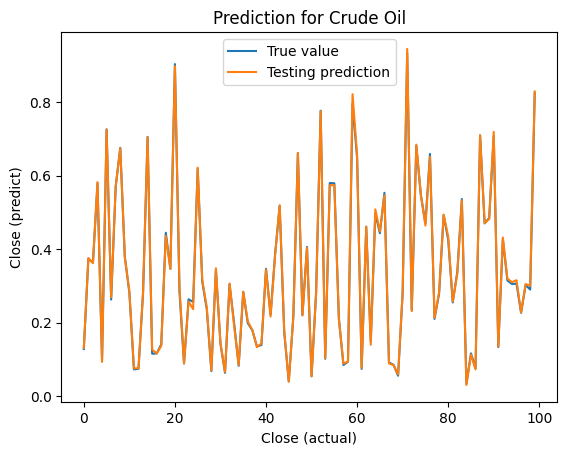

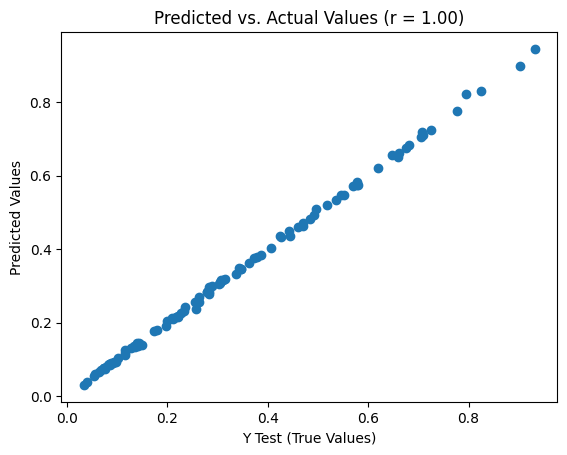

In [40]:
# @title Splitting DataSet { form-width: "50px" }
from scipy.stats import pearsonr, shapiro


linearRegressionModel = LinearRegressionModel()


def compute_accuracy(y_true, y_pred):
    accuracy = 1- np.sum(np.abs((y_true - y_pred)) / y_true) / len(y_true)
    return accuracy

# Train data and plot a graph betwwen accuracy and y_prediction

# 1.) Brute Oil
linearRegressionModel.fit(X_train, y_train)
y_predict = linearRegressionModel.predict(X_test)

y_test_tensor = torch.tensor(y_test.to_numpy().reshape((-1, 1))).float()
y_predict_tensor = torch.tensor(y_predict.reshape((-1, 1))).float()

accuracy = compute_accuracy(y_test.to_numpy(), y_predict)
print("Accuracy for Crude Oil: ", accuracy)
plt.plot(y_test_tensor[:100], label='True value')
plt.plot(y_predict_tensor[:100], label='Testing prediction')
plt.xlabel('Close (actual)')
plt.ylabel('Close (predict)')
plt.title("Prediction for Crude Oil")
plt.legend()
plt.show()

plt.scatter(y_test[:100], y_predict[:100])
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values (r = {0:0.2f})'.format(pearsonr(y_test[:100], y_predict[:100])[0], 2))
plt.show()

